# Using pre-trained network for bone age problem
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. We will be using a pretrained network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [3]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/mode951.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode982.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model007.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/model046.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode_tmp.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model-13-epochs-8.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model025.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-300'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model004.pth'

In [4]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


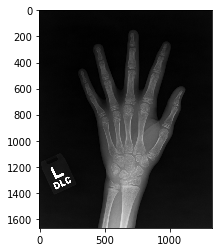

In [5]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [6]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [7]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [8]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They used 500x500 images.

In [9]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

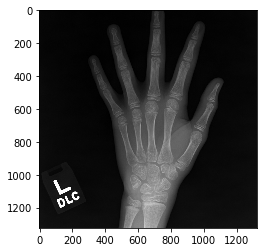

In [10]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

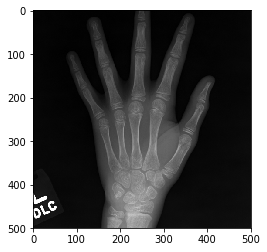

In [11]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

5.336596724658813


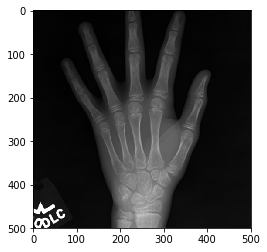

In [12]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

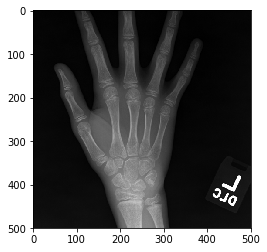

In [13]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [15]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

In [15]:
a = train.head()

In [16]:
row = a.iloc[0]
b = (1 if row["male"] == True else 0)
b

1

In [17]:
b = int(row["male"] == True)
b

1

## Dataset

In [40]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=300):
        self.path_to_images = PATH/"boneage-300/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x2 = int(row["male"])
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        x = normalize(x)
        return np.rollaxis(x, 2), x2, y[None]

In [41]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [42]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [43]:
# run this multiple times to get different images
x1, x2, y = train_ds[10]
x2

1

In [44]:
x1.shape,x2,y

((3, 300, 300), 1, array([216]))

## Model

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.out = 512 + 32
        self.bn0 = nn.BatchNorm1d(32)
        self.bn1 = nn.BatchNorm1d(self.out)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc0 = nn.Linear(1, 32)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x1, x2):
        x1 = F.relu(self.top_model(x1))
        x1 = nn.AdaptiveAvgPool2d((1,1))(x1)
        x1 = x1.view(x1.shape[0], -1)
        x2 = self.fc0(x2.unsqueeze(1)).float()
        x2 = self.bn0(F.relu(x2)) 
        x = torch.cat([x1, x2], 1)
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [46]:
model = Net().cuda()

In [47]:
x1, x2, y = next(iter(train_dl))

In [48]:
x1 = x1.cuda().float()
x2 = x2.cuda().float()
y = y.cuda().float()

In [29]:
x1.shape, x2.unsqueeze(1).shape

(torch.Size([16, 3, 300, 300]), torch.Size([16, 1]))

In [49]:
y_hat = model(x1, x2)

In [50]:
# F.l1_loss
F.l1_loss(y_hat, y).item()

132.9613037109375

## Learning rate finder

In [37]:
def get_optimizer(model, lr = 0.01):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=0)
    return optim

In [38]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x1, x2, y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x1 = x1.cuda().float()
            x2 = x2.cuda().float()
            y = y.cuda().float()
            out = model(x1, x2)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [51]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

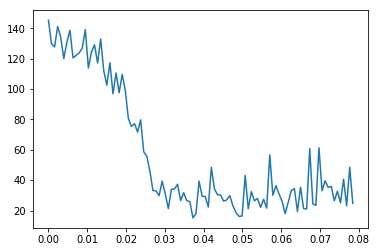

In [52]:
plt.plot(lrs[:100], losses[:100])
plt.show()

## Triangular learning rate training

In [53]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [61]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [81]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.012, epochs=4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x1, x2, y in train_dl:
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x1 = x1.cuda().float()
            x2 = x2.cuda().float()
            y = y.cuda().float()
            out = model(x1, x2)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [76]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        x1 = x1.cuda().float()
        x2 = x2.cuda().float()
        y = y.cuda().float()
        out = model(x1, x2)
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss", sum_loss/total)

## Training with triangular rates

In [77]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-5, lr_high=0.03, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [78]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [100]:
model = Net().cuda()

In [101]:
training_loop(model, train_dl, valid_dl, epochs=8)

train loss 52.307621447982584
val loss 20.164763841621465
train loss 20.33738135970115
val loss 20.679247238255986
train loss 20.535797342600443
val loss 18.524891789048368
train loss 19.741760138584347
val loss 22.258023943435948
train loss 17.981664383655993
val loss 18.97174087391308
train loss 17.0799563261666
val loss 18.064920936663125
train loss 16.865137874388886
val loss 17.37116617177045
train loss 16.585608255970712
val loss 17.47312512953635
----End of step Time elapsed 0:17:30.019182


In [102]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b
        
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [103]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)
unfreeze(model, 4)
unfreeze(model, 3)
unfreeze(model, 2)
unfreeze(model, 1)

In [104]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=1e-4, epochs=8)

train loss 15.532333555513643
val loss 13.659182123491256
train loss 14.168994007078457
val loss 13.323588989917292
train loss 13.188496433030815
val loss 12.257728510107151
train loss 12.174887705657442
val loss 12.7170174452731
train loss 11.306267093957528
val loss 9.18591571780635
train loss 10.77025594152654
val loss 8.947120431299535
train loss 10.590861015459723
val loss 8.96760570880064
train loss 10.446973132359307
val loss 8.355981657374576
----End of step Time elapsed 0:23:16.124793


In [30]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [31]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.data[0])
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [32]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return loss.data[0]

In [33]:
from datetime import datetime
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs):
        start = datetime.now()
        loss = train_model(model, optim, train_dl)
        end = datetime.now()
        t = 'Time elapsed (hh:mm:ss.ms) {}'.format(end - start)
        print("loss ", i, loss, t)
        val_loss(model, valid_dl)

In [202]:
model = Net().cuda()

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb